As we begin the process of ingesting our Wave 1 Ethica telemetry data, we have encountered some unexpected conditions in the data. This document is a record of my attempts to quantify and understand these issues, in the hope that we can then find a protocol for filtering the data and make it useful to our research.

In a nutshell, there are three fundamental issues: 
    
1. There is significantly more data than expected, with some of the files having 3 or 4 times as many records as were predicted.
1. Much of the data is contradictory, with many cases where multiple records occur for the same user at the same time, but with conflicting sensor values.
1. Disagreement between the satellite_time and record_time fields in the GPS data raises questions about whether the GPS and Accelerometry tables are synchronized.

These circumstances have been found in both Saskatoon and Victoria so far, but for the purposes of this report, all examples are taken from the Saskatoon Wave 1 data. (Ethica study #448) 

# Issue #1: Volume of Data

The data files we receive from Ethica were exported directly from the Ethica Cassandra node into CSV-format tables. Each CSV contains one type of sensor data, with observations for all users in the study. Each line in the file represents a single sensor value recorded for a single participant at a single moment in time, measured in milliseconds. GPS data is recorded approximately once per second, accelerometers are recorded at 20 Hz (appx ever 0.05s), and the battery records are captured appx every 5 minutes. The expectation is that the records in the battery table represent the start of each capture window (duty cycle), and that the GPS and Accel tables will be captured only during the first minute of each window.

The GPS data file contains approximately 29M samples. This is supposed to mean that we have 29M unique observations of our participant cohort, with each sample recording a particular user in a particular location at a unique point in time. However, when we count the number of unique pairings of userid and timestamp, we get only 8M. (The timestamp field we're using is the record_time column, but examining the satellite_time field produces a similar ratio as well.) 

This suggests that there is a lot of redundancy in the files, with 3 or 4 times as many records as there should be.

An important part of our ingest process is to filter out redundant timestamps to ensure that our analysis has well-ordered timeseries data to work with. So to filter the Ethica stream, we'll need a better understanding of what that redundancy looks like. If all the redundant records are clustered in a few focused periods of time where the capture tech became 'glitchy', then we can just drop records from those confused periods. But if the conflicted captures are diffused more generally throughout the data, we'll have to devise a more sophisticated filtration scheme.

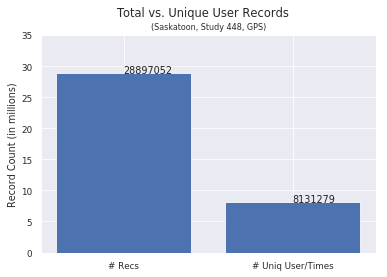

In [3]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import psycopg2
import psycopg2.extras
import seaborn as sns
import matplotlib

# tell Seaborn that we're producing a document and not a slideshow or poster
sns.set()
sns.set_context('paper')

# expects to find connection credentials in local runtime environment
db_host=os.environ['SQL_LOCAL_SERVER']
db_host_port=int(os.environ['SQL_LOCAL_PORT'])
db_user=os.environ['SQL_USER']
db_name=os.environ['SQL_DB']
db_schema=os.environ['SQL_SCHEMA']
    
sql_tot = """
            SELECT count(1) from level_0.tmpsskgps;
            """

sql_uniq_timestamps = """
            SELECT count(1) as num_uniq_times 
            FROM ( 
                SELECT count(1), user_id, record_time 
                FROM level_0.tmpsskgps 
                GROUP BY user_id, record_time
            ) sub;
"""

data = {}
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor()
    
    # count all the records in the SSK GPS table
    cur.execute(sql_tot)
    row = cur.fetchone()
    data['# Recs'] = row[0]
    
    # count the uniq user_id/timestamps in SSK GPS table
    cur.execute(sql_uniq_timestamps)
    row = cur.fetchone()    
    data['# Uniq User/Times'] = row[0]

plt.bar(data.keys(), data.values())
for name in data.keys():
    plt.text(name, data[name], f"{data[name]}")
plt.ylabel("Record Count (in millions)")
yvals,ystrs = plt.yticks()
ylabels = [f"{int(y/1000000)}" for y in yvals]
plt.yticks(yvals, ylabels)
plt.suptitle("Total vs. Unique User Records")
plt.title("(Saskatoon, Study 448, GPS)", fontsize=8)
plt.save('unique-records.png',dpi=300)

## Classifying Duplicates

The first question is how the duplicates are distributed. Is every record captured 3 times? Is one record repeated 20M times? Are there ghost users in the table who shouldn't be there?

For the purposes of this document, I'll refer to each unique combination of user-id and timestamp as an *ObservationID*. We'll begin the investigation by taking some simple counts of ObservationID to get a sense of how the data is organized. 

In [24]:
from IPython.display import display
from tabulate import tabulate

sql_count_users = """SELECT COUNT(1) AS num_users 
                     FROM (
                         SELECT DISTINCT user_id 
                         FROM level_0.tmpsskgps
                     ) as isolator;
                     """

sql_find_dups = """
    SELECT SUM(recs_per_user_time::int) filter (WHERE recs_per_user_time = 1) as tot_singletons,
           SUM(recs_per_user_time::int) filter (WHERE recs_per_user_time > 1) as tot_duplicates,
           SUM(recs_per_user_time::int) filter (WHERE recs_per_user_time = 1)
              + SUM(recs_per_user_time::int) filter (WHERE recs_per_user_time > 1) as tot_records,
           COUNT(recs_per_user_time::int) filter (WHERE recs_per_user_time > 1) as num_duplicated_stamps,
           SUM(recs_per_user_time::int) filter (WHERE recs_per_user_time = 1) 
              + COUNT(recs_per_user_time::int) filter (WHERE recs_per_user_time > 1) as num_uniq_stamps
    FROM (
        SELECT COUNT(1) AS recs_per_user_time, user_id, record_time
        FROM level_0.tmpsskgps
        GROUP BY user_id, record_time
    ) unique_user_times;
"""

with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    cur.execute(sql_count_users)
    row = cur.fetchone()
    num_users = row[0]
    
    cur.execute(sql_find_dups)
    row = cur.fetchone()
    data[0].extend(list(row.keys()))
    data[1].extend([f"{x:,}" for x in row.values()])
    data = [ list(row.keys()), [f"{x:,}" for x in row.values()] ]
    data = [[data[0][x],data[1][x]] for x in range(0,len(data[0]))]
    data.append(['num_users',num_users])
    print(tabulate(data,stralign='right'))

    

---------------------  ----------
       tot_singletons   7,729,649
       tot_duplicates  21,167,403
          tot_records  28,897,052
num_duplicated_stamps     401,630
      num_uniq_stamps   8,131,279
            num_users         151
---------------------  ----------


From this result, we can see that the table only has 151 users, which is the expected number, so the excess records aren't coming from ghost users.

The count of ObservationIDs shows that there are 7.7M truly unique ObservationIDs, and then an additional 21M records that are not unique.

Within those 21M duplicates, there are only 400K distinct ObservationIDs.

So we don't yet know why there are so many records, but despite the large number of them, they only represent about 5% of the unique observations available in the dataset.

# Issue #2: Data Conflicts 

The next question is to discern how the captured sensor values behave within these redundant records. Is it a case of simple *output stuttering*, in which multiple identical records are being recorded, or do the sensor values change? To examine this, we'll break the redundant records down further, grouping by sensor values as well as ObservationID.

In [22]:
sql = """
    SELECT COUNT(1) as num_users,
           SUM(num_singletons)::int as tot_singletons,
           SUM(num_singleton_equivalent)::int as tot_singleton_equivalent,
           MIN(minconflictgroups) as minconflictgroups,
           MAX(maxconflictgroups) as maxconflictgroups,
           AVG(avgconflictgroups) as avgconflictgroups,
           SUM(numconflictgroups) as trueconflictgroups,
           SUM(num_records)::int as tot_records
    FROM (
        --- classify conflict groups by uniqueness, per user
        SELECT user_id,
            COUNT(1) filter (where totrecs = 1) as num_singletons,
            COUNT(1) filter (where totrecs != 1 and numconflictgroups = 1) as num_singleton_equivalent,
            MIN(numconflictgroups) as minconflictgroups,
            MAX(numconflictgroups) as maxconflictgroups,
            AVG(numconflictgroups) as avgconflictgroups,
            COUNT(1) filter (where totrecs > 0) as num_records,
            COUNT(1) filter (where numconflictgroups > 1) as numconflictgroups
        FROM (
            -- count number of conflict groups
            SELECT user_id, totrecs, numconflictgroups, record_time
            FROM (
                -- group into records of distinct observations sharing identical timestamps
                SELECT count(1) as numconflictgroups, sum(dupls) as totrecs,
                    user_id, record_time,
                    min(lat) as lat, min(lon) as lon -- shld be min of identical values
                FROM (
                    -- count identical observations
                    SELECT count(1) as dupls, user_id, record_time, lat, lon
                    FROM level_0.tmpsskgps
                    GROUP BY user_id, record_time, lat, lon
                    ORDER BY user_id, record_time, lat, lon
                    ) as duplicates
                GROUP BY user_id, record_time
            ) as conflicts
        ) conflict_counts
        GROUP BY user_id
    ) computed_totals;
"""

with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,f"{int(row[x]):,}"] for x in row.keys()]
    print(tabulate(data, stralign='right'))


------------------------  ---------
               num_users        151
          tot_singletons  7,729,649
tot_singleton_equivalent     62,294
       minconflictgroups          1
       maxconflictgroups        113
       avgconflictgroups          2
      trueconflictgroups    339,336
             tot_records  8,131,279
------------------------  ---------


Here we define a *singleton_equivalent* group to mean a set of redudant records that all share the same ObservationID, but exhibit only 1 unique sensor reading among them. In theory, these could be collapsed into true singleton records and kept as part of the dataset, but without understanding more about their origin, it may be more prudent to filter them out. Especially since they represent less than 1% of the unique observations in the set.

Of greater concern is that 113, which means that in at least one case, a single user had 113 different sensor readings all reporting the same millisecond timestamp. These true conflicts occur in 300K distinct sets throughout the table, so they comprise about 4% of the unique sensor readings in the file.

Like the singleton_equivalent records, it seems prudent to simply drop these records. Taking both classes of conflict together, this would result in filtering out 21M records (75% of the raw data) but only losing 400K observations, or about 4.9% of the unique observations available in the file.

But before proceeding with that decision, it would be helpful to understand how these records are distributed in time, within each user's history. It has been suggested that in some datasets, the redundancies occurred at the start of duty cycles. Does this hold true for our data?

## Conflict Timing
In this next analysis, we'll look at the specific timelines of 10 different users, selected at random from the dataset. By graphing the number of redundant records against the timestamp at which they occur, we may be able to detect a pattern.

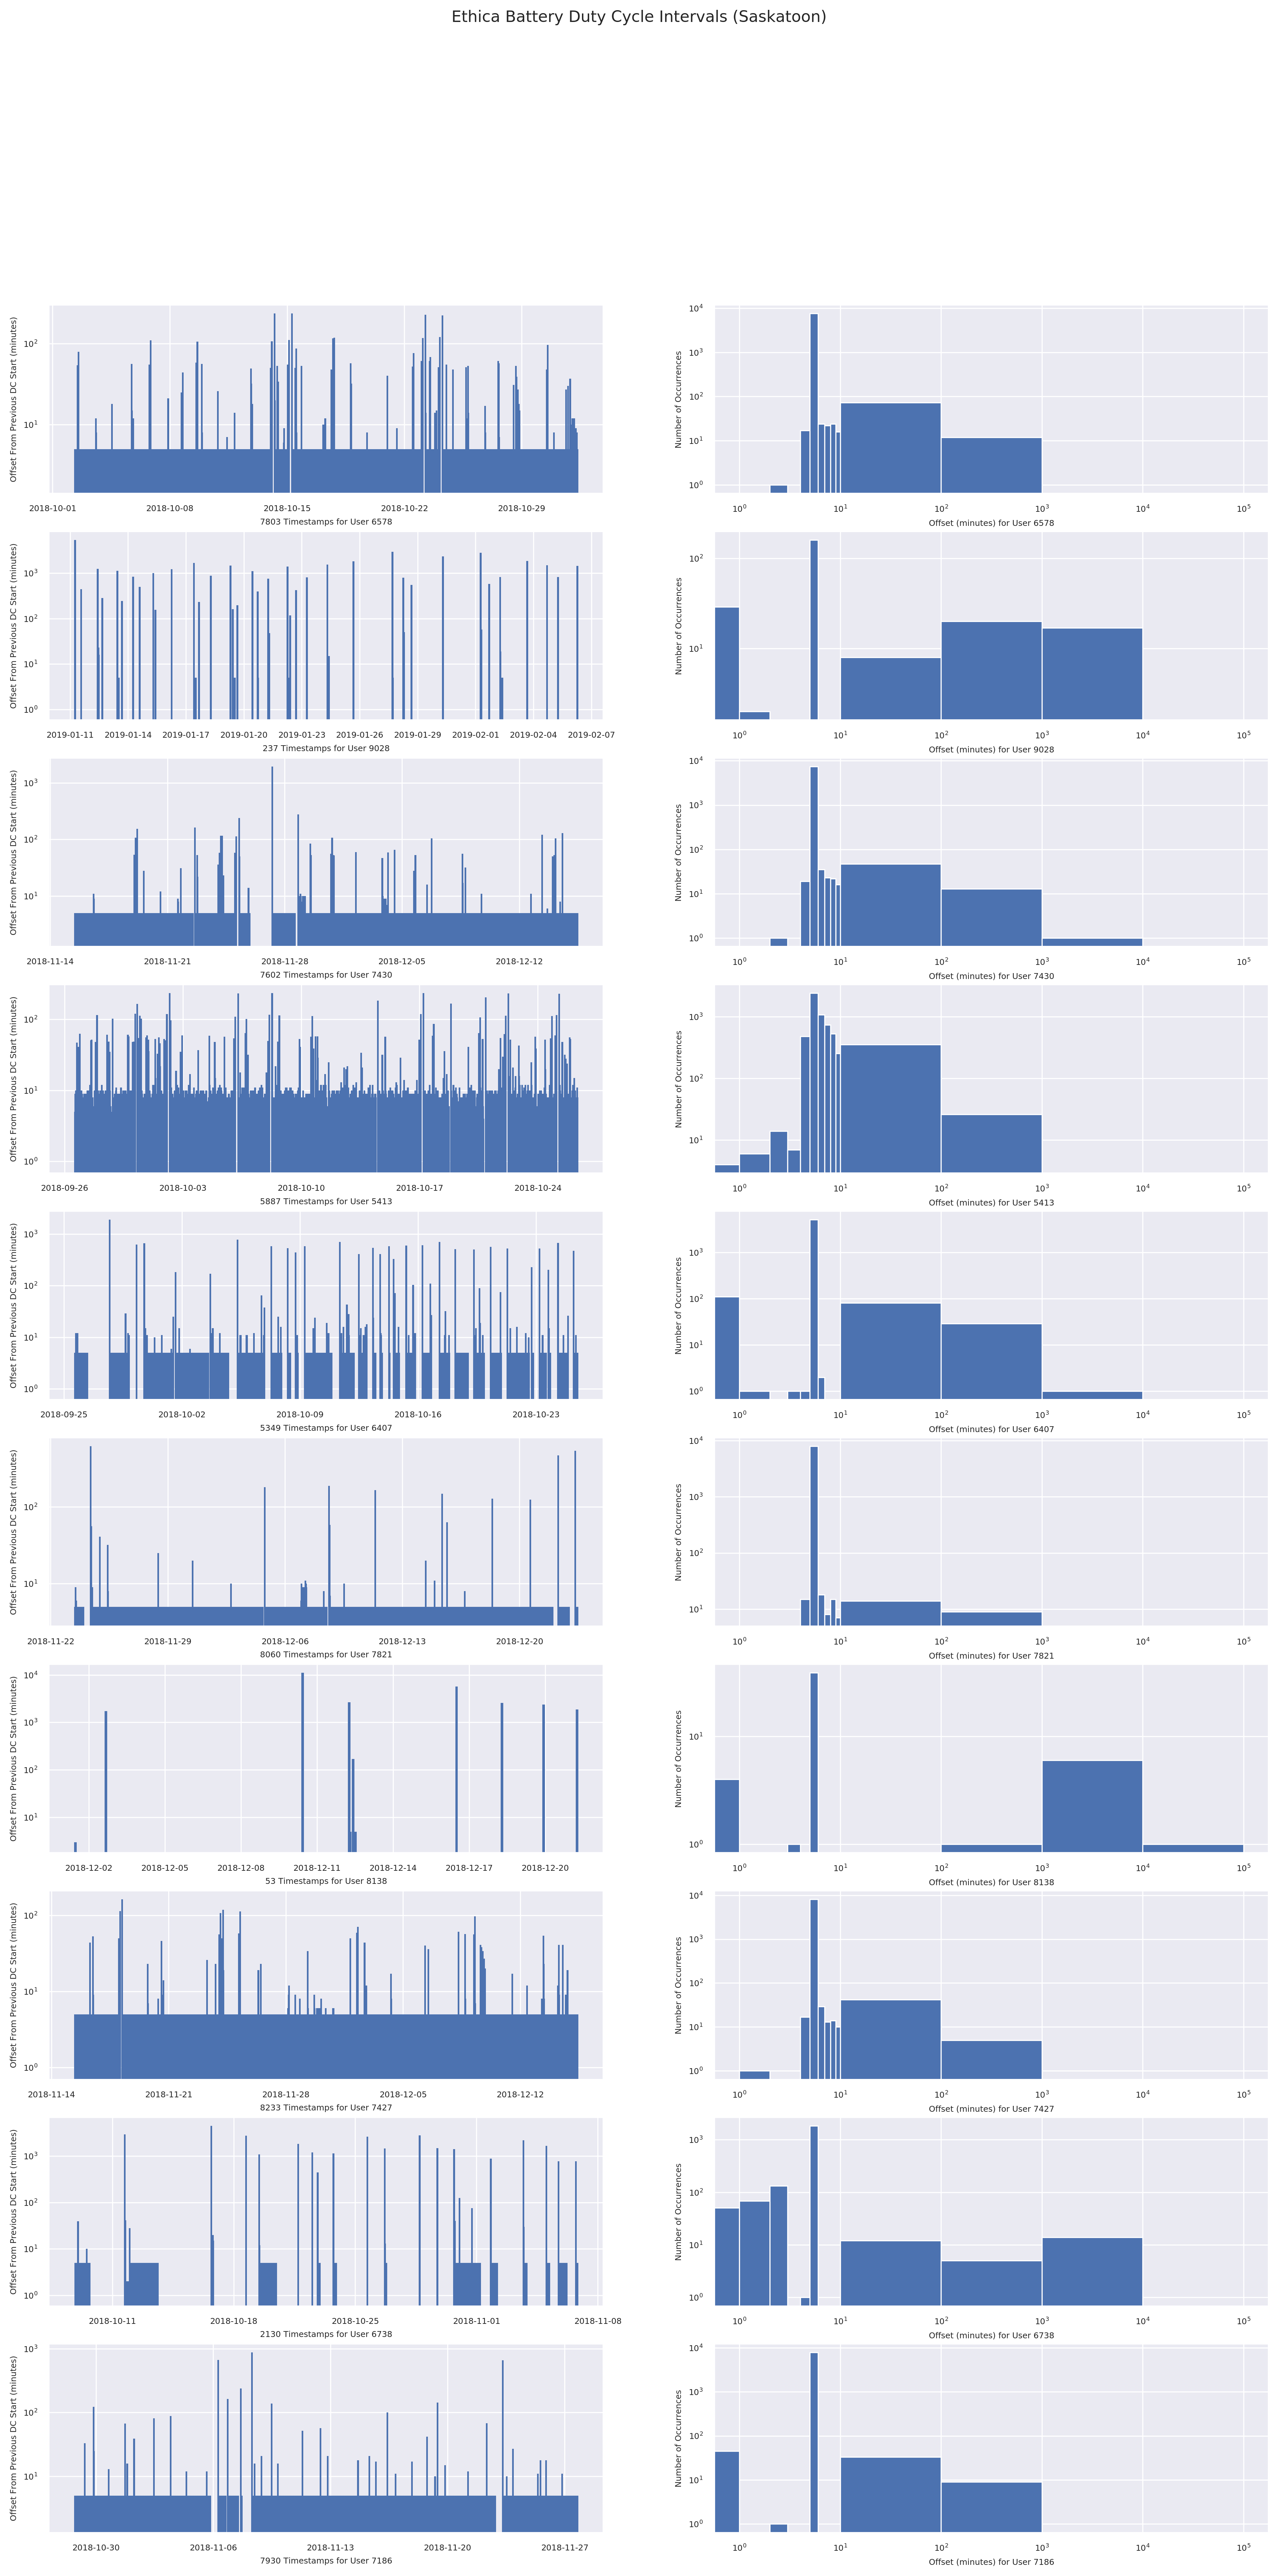

In [4]:
import random as rnd
import collections
import matplotlib as mpl
import datetime

# suppress implicit registration warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# set higher dpi for HTML display
mpl.rcParams['figure.dpi'] = 300 

# select all unique ObservationIDs in battery table
user_dc_signals_sql = """SELECT user_id, record_time
                         FROM level_0.tmpsskbatt
                         ORDER BY user_id, record_time;
                         """

def compute_spacing(timestamps, timelimitseconds = None):
    """
    Given a series of timestamps, return a list of ms offsets
    between successive entries in the series.
    Assumes the timestamps are sorted in ascending order.
    If a timelimit is specified, only those samples within that timelimit
    of the first sample will be returned.
    """
    last = None
    minute_spaces = []
    for i,this in enumerate(timestamps):
        if timelimitseconds:
            windowsize = this - timestamps[0]
            if windowsize > datetime.timedelta(seconds=timelimitseconds):
                break
        if this and last:
            interval = this - last
            diff_s = interval.total_seconds()
            minute_spaces.append( int(round(diff_s/60.0, 0)) )
        else:
            minute_spaces.append(-1)
        last = this
    return minute_spaces


# Create connection to DB...
with psycopg2.connect(user=db_user,
                    host=db_host,
                    port=db_host_port,
                    database=db_name) as conn:

    # Get user list...
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    cur.execute(user_dc_signals_sql)
    all_signals = cur.fetchall()
    users = set([x['user_id'] for x in all_signals])

    numusers = 10 
    f, axs = plt.subplots(numusers,2,figsize=(16,3*numusers))
    f.suptitle("Ethica Battery Duty Cycle Intervals (Saskatoon)")

    # Draw signal spacing histograms for 2 randomly selected users
    rnd.seed(17) # ensure same users chosen each time
    for i,user in enumerate(rnd.sample(users,numusers)):
        # First, compute spacings between each successive timestamp
        user_signals = [x['record_time'] for x in all_signals if x['user_id'] == user]
        user_spacings = compute_spacing(user_signals)

        # set the bin spacings for use in the histogram
        bins = [0,1,2,3,4,5,6,7,8,9,10,100,1000,10000,100000]

        # Plot each DC trigger showing delta time from previous trigger
        # Note: Dropping the first sample, since it is known to have no prior time
        axs[i,0].set_yscale('log')
        axs[i,0].bar(user_signals[1:], user_spacings[1:], 
                     width=0.1, linewidth=0)
        axs[i,0].set_xlabel(f'{len(user_signals)} Timestamps for User {user}',fontsize=6)
        axs[i,0].set_ylabel(f'Offset From Previous DC Start (minutes)',fontsize=6)
        #axs[i,0].set_yticks(bins)
        axs[i,0].tick_params(axis='both', which='major', labelsize=6)
        axs[i,0].tick_params(axis='both', which='minor', labelsize=4)

        # Plot histogram of offset values: most should be around 5-minutes
        # logarithmic vertical axis
        axs[i,1].set_xscale('log')
        axs[i,1].set_yscale('log')
        axs[i,1].get_xaxis().get_major_formatter().labelOnlyBase = False
        axs[i,1].hist(user_spacings[1:], bins=bins)
        #axs[i,1].set_yticks(bins)
        axs[i,1].set_xlabel(f'Offset (minutes) for User {user}',fontsize=6)
        axs[i,1].set_ylabel('Number of Occurrences',fontsize=6)
        axs[i,1].tick_params(axis='both', which='major', labelsize=6)
        axs[i,1].tick_params(axis='both', which='minor', labelsize=4)


For each of these 10 users, the graph on the left plots each unique timestamp in their battery file against a count of how many records are reported for that time. The 2nd, 7th, and 9th users from the top (id = 9028, 8138, and 2130) clearly have very little data, but the rest all have 5000 or more of the 8000 theoretical maximum DCs per day. (A 28-day study running 24-hrs per day, with 12 duty cycles per hour.)

The figures on the right show the distribution of offset times between successive DCs for that user, rounded to the nearest minute. In all cases, the most common DC period was 5 minutes, which is to be expected. The presence of longer delays was also expected, since the devices are occasionally turned off or low on power. But in those cases, there should only be 1 record to mark the resumption of power following the gap in service.

At this resolution, there do not appear to be any obvious patterns for where/when duplicate records occur. So the next test will be to examine the same data, but in a narrower window, so the service gaps are more plainly visible.

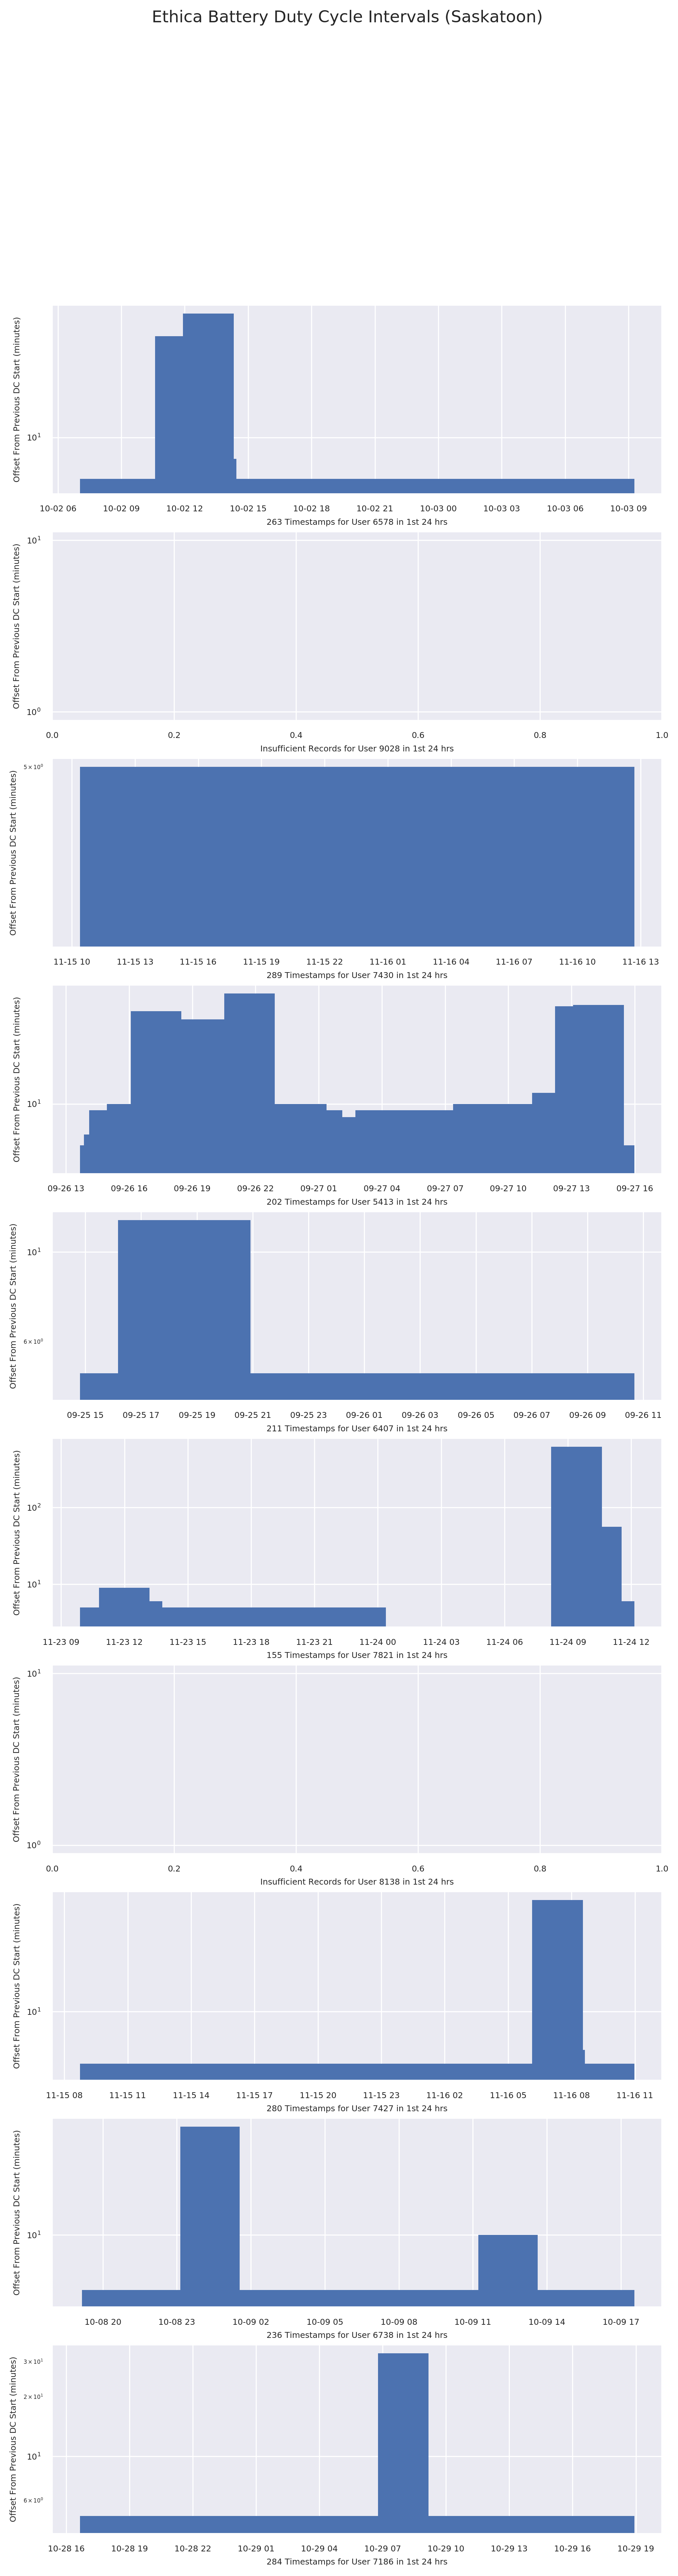

In [5]:
# Create connection to DB...
with psycopg2.connect(user=db_user,
                    host=db_host,
                    port=db_host_port,
                    database=db_name) as conn:

    # Get user list...
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    cur.execute(user_dc_signals_sql)
    all_signals = cur.fetchall()
    users = set([x['user_id'] for x in all_signals])

    numusers = 10 
    f, axs = plt.subplots(numusers,1,figsize=(8,3*numusers))
    f.suptitle("Ethica Battery Duty Cycle Intervals (Saskatoon)")

    # figure out how many records to show
    # Choose the 1st 24 hours of data, expressed in seconds
    oneday = 24*60*60

    # Draw signal spacing histograms for randomly selected users
    rnd.seed(17) # ensure same users chosen each time
    for i,user in enumerate(rnd.sample(users,numusers)):
        # First, compute spacings between each successive timestamp
        user_signals = [x['record_time'] for x in all_signals if x['user_id'] == user]
        user_spacings = compute_spacing(user_signals, timelimitseconds=oneday)
        
        axs[i].set_yscale('log')
        axs[i].tick_params(axis='both', which='major', labelsize=6)
        axs[i].tick_params(axis='both', which='minor', labelsize=4)
        axs[i].set_ylabel(f'Offset From Previous DC Start (minutes)',fontsize=6)
        

        if len(user_spacings) > 10: # bail if not enough samples in 1st day
            # truncate signal list to match length of retained user_spacings
            user_signals = user_signals[:len(user_spacings)]

            # set the bin spacings for use in the histogram
            bins = [0,1,2,3,4,5,6,7,8,9,10,100,1000,10000,100000]


            # Plot each DC trigger showing delta time from previous trigger
            # Note: Dropping the first sample, since it is known to have no prior time
            axs[i].bar(user_signals[1:], user_spacings[1:], 
                         width=0.1, linewidth=0)
            axs[i].set_xlabel(f'{len(user_spacings)} Timestamps for User {user} in 1st 24 hrs',fontsize=6)
        else:
            axs[i].set_xlabel(f'Insufficient Records for User {user} in 1st 24 hrs',fontsize=6)

Unfortunately, there appears to be no pattern to the occurrences of duplicate records. Some do indeed occur immediately after a gap, but others occur in the middle of what appear to be continuous runs. Additionally, all the users examined showed evidence of redundant samples, so it is not likely isolated to specific users or specific phone configurations.

# Issue #3: Signal Registration
One last concern is whether the data in the GPS, accelerometer, and battery tables are synchronized. We'll look at the how well or poorly the timestamps in the telemetry tables align with the expectations created by the duty cycle signals in the battery table.  As we understand it, the Ethica software attempts to keep the duty cycles aligned with clock time. If this is the case, then we should see peaks of samples occurring in the 0, 5, 10, 15...55 minute bins for each table.


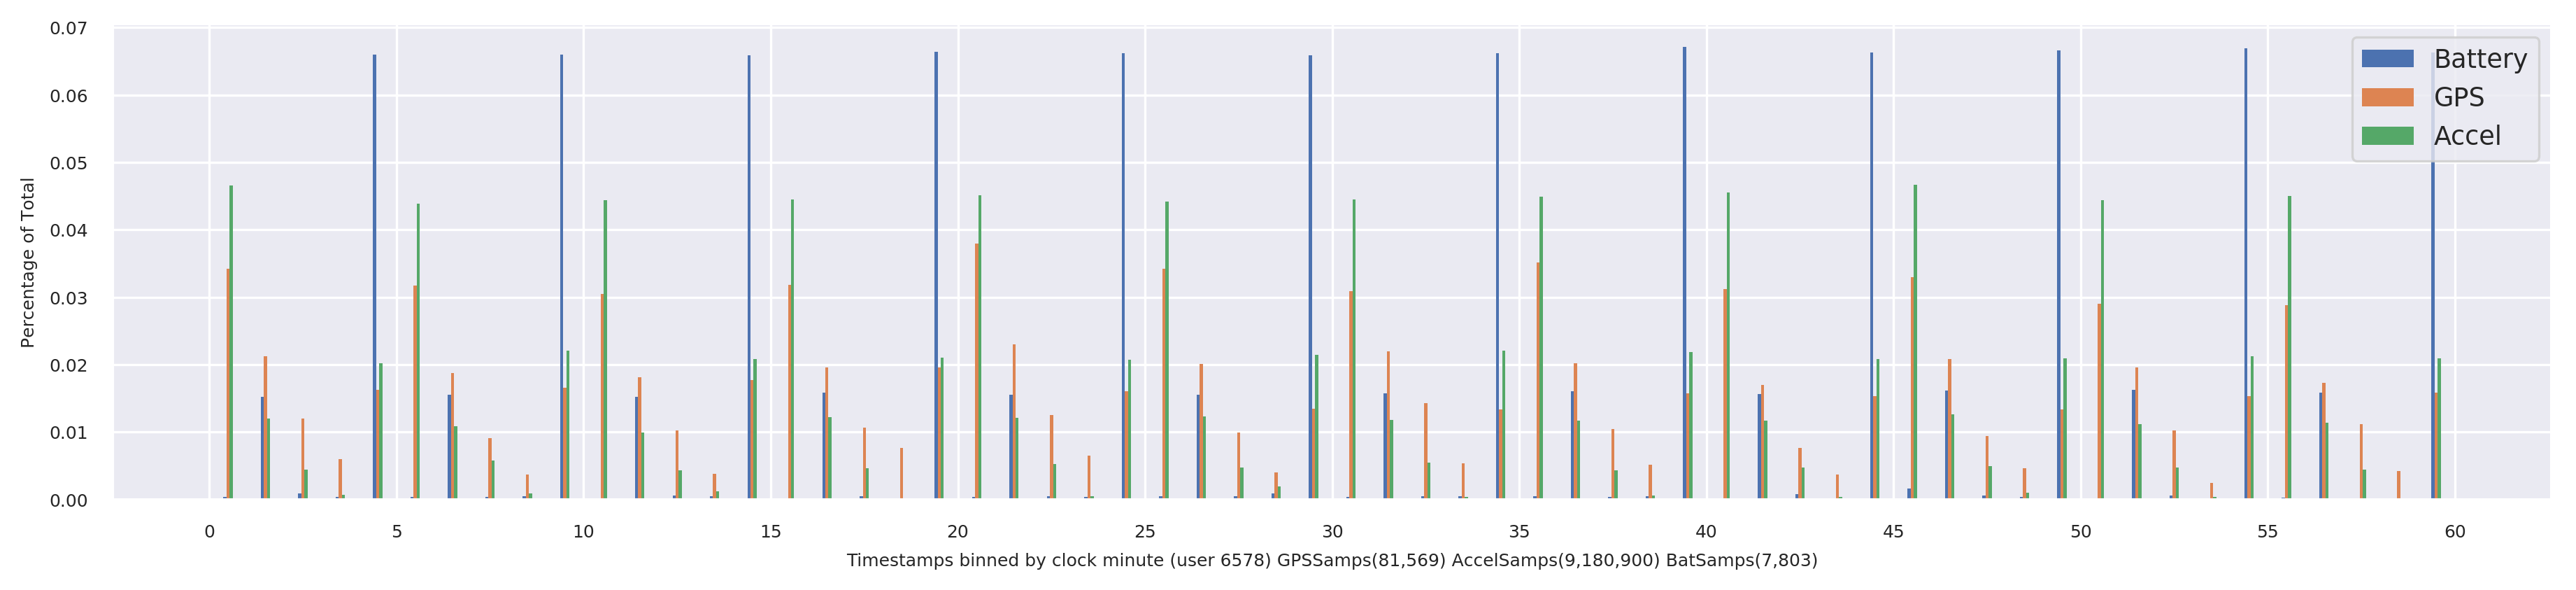

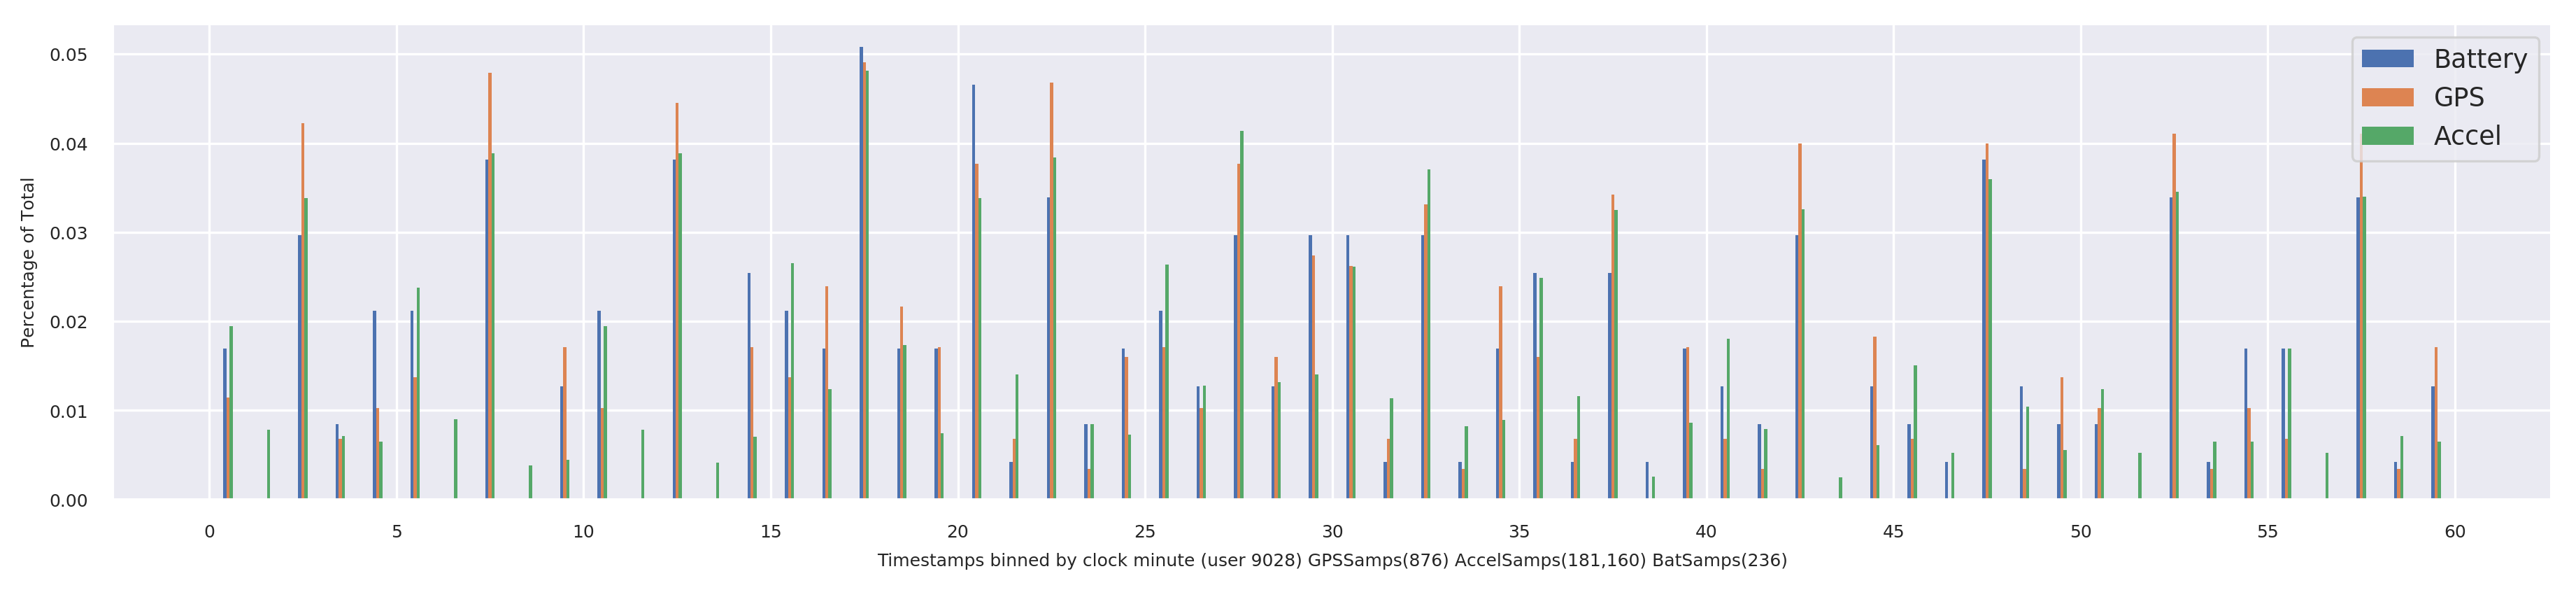

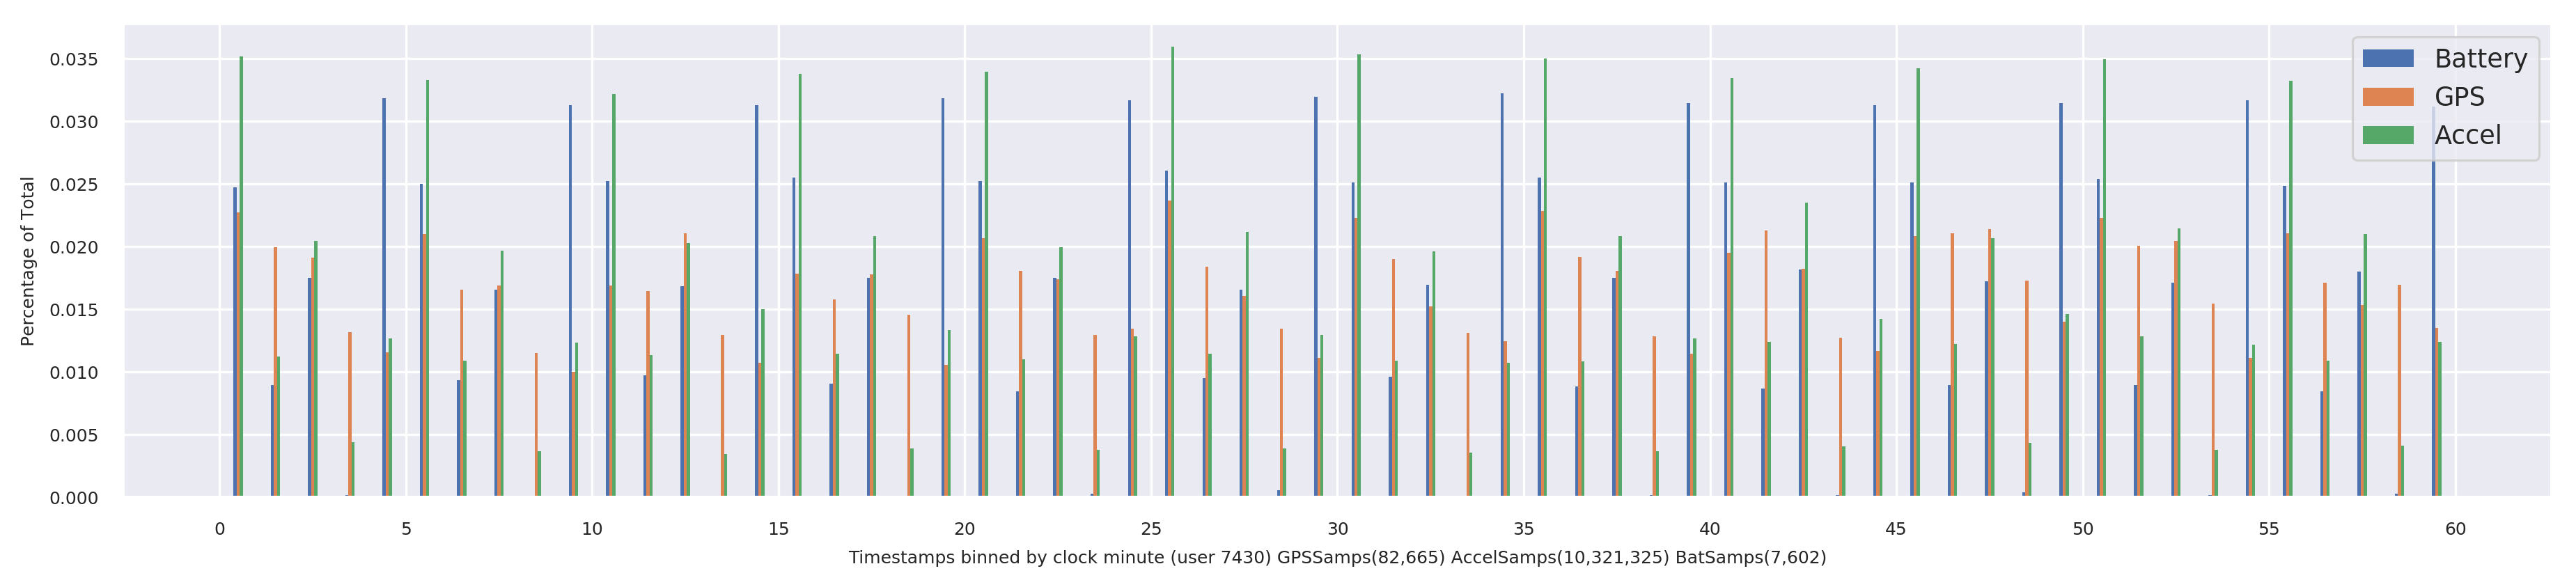

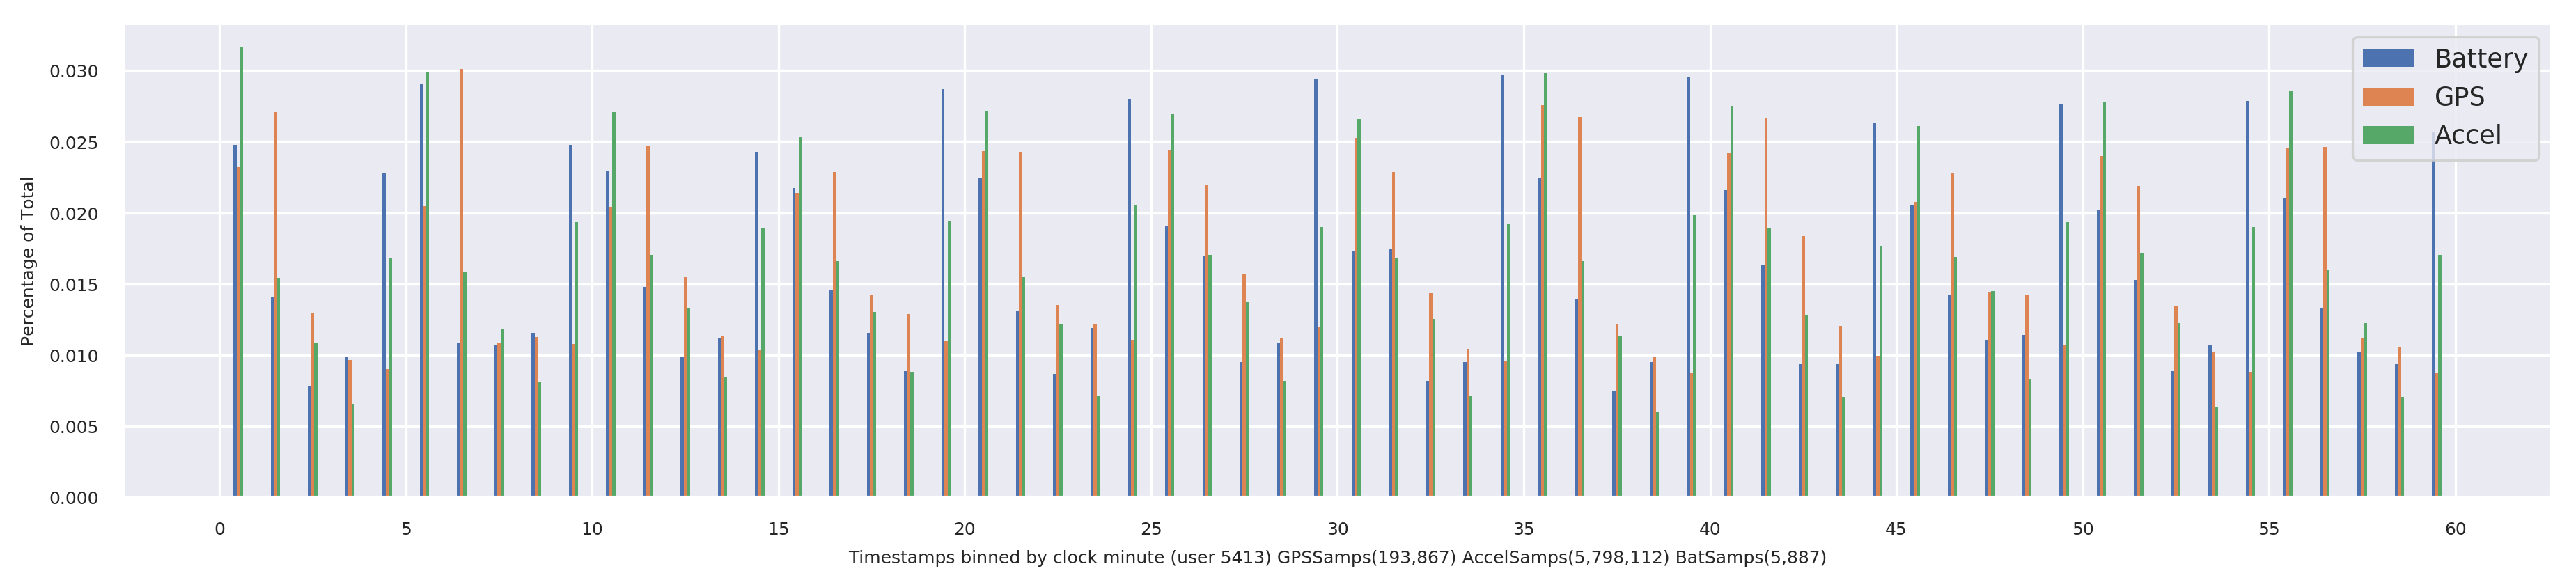

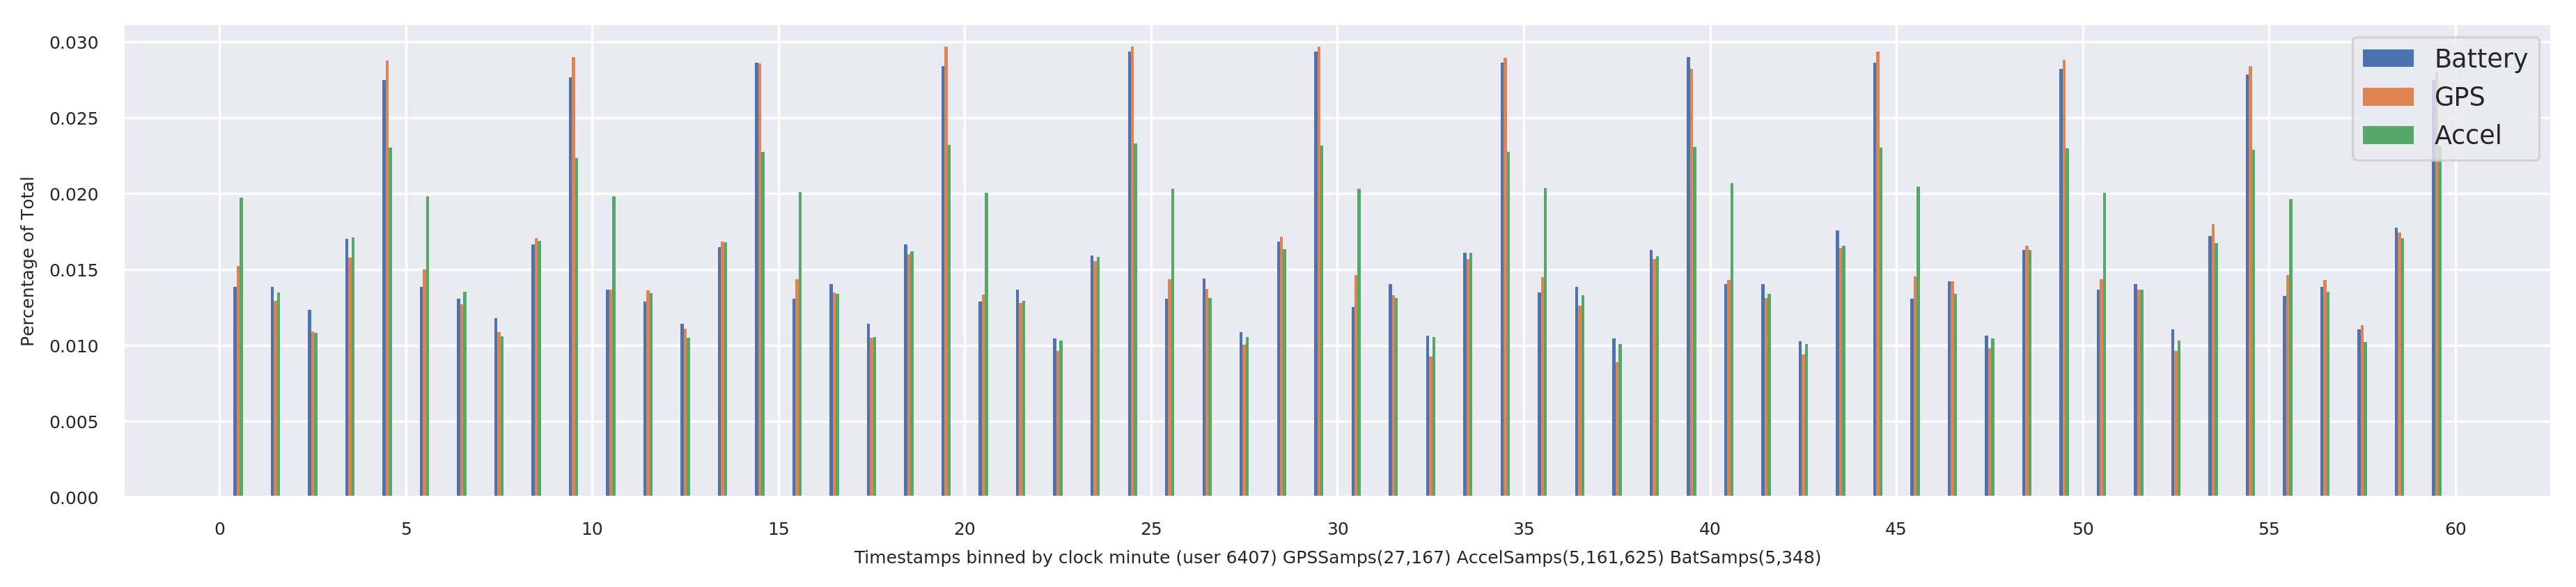

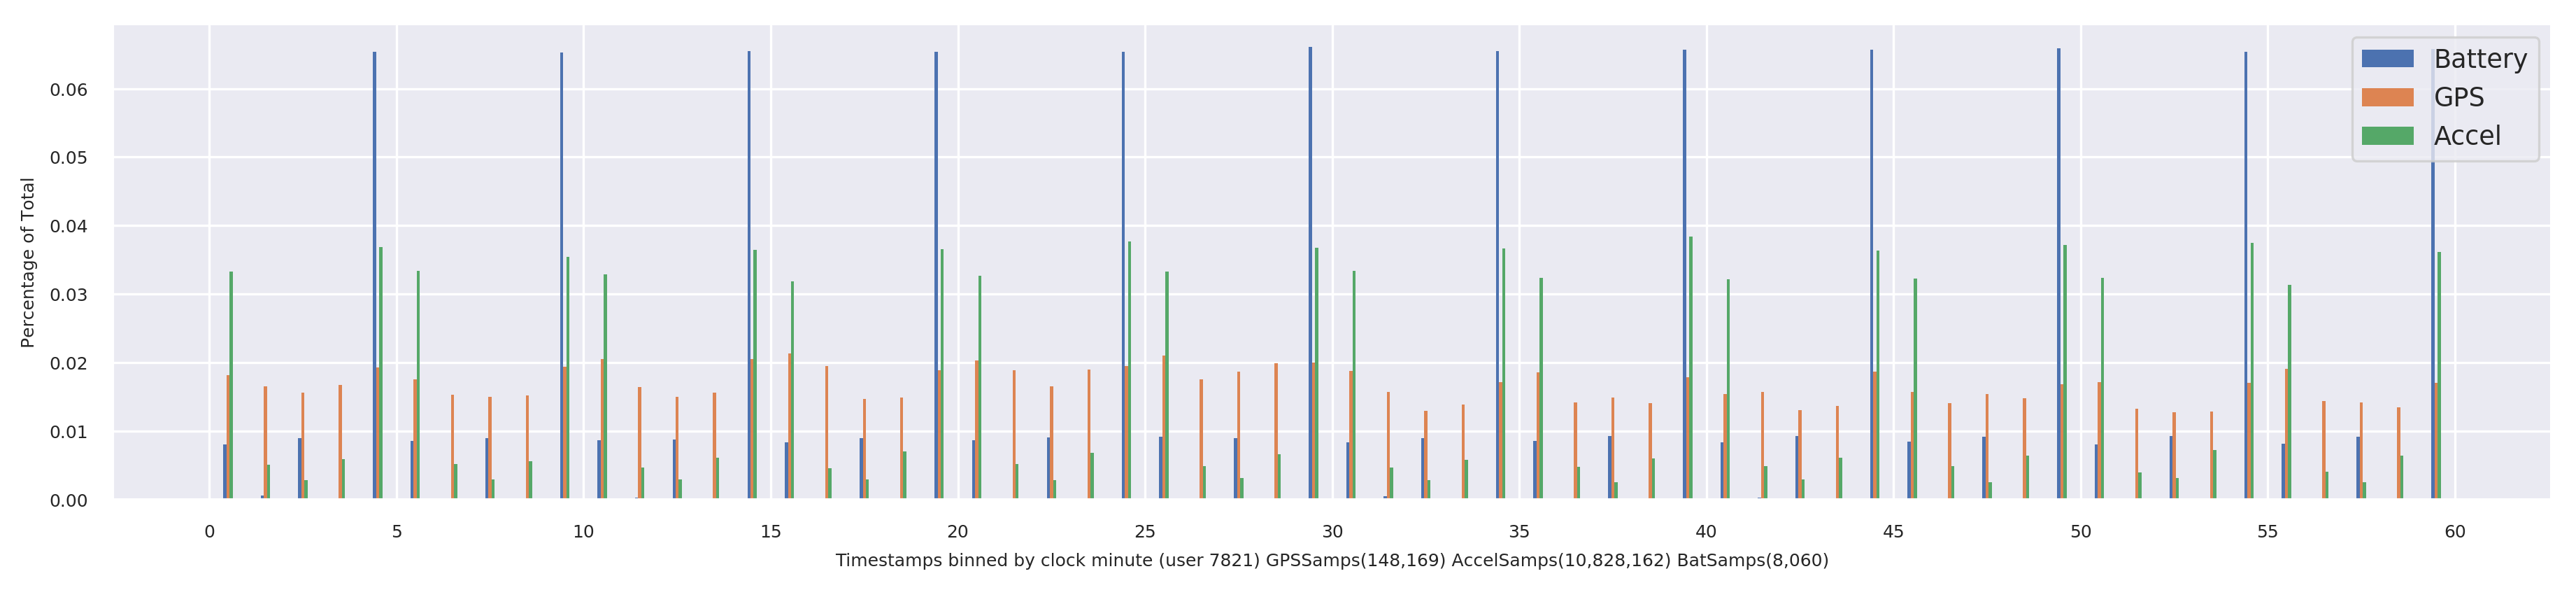

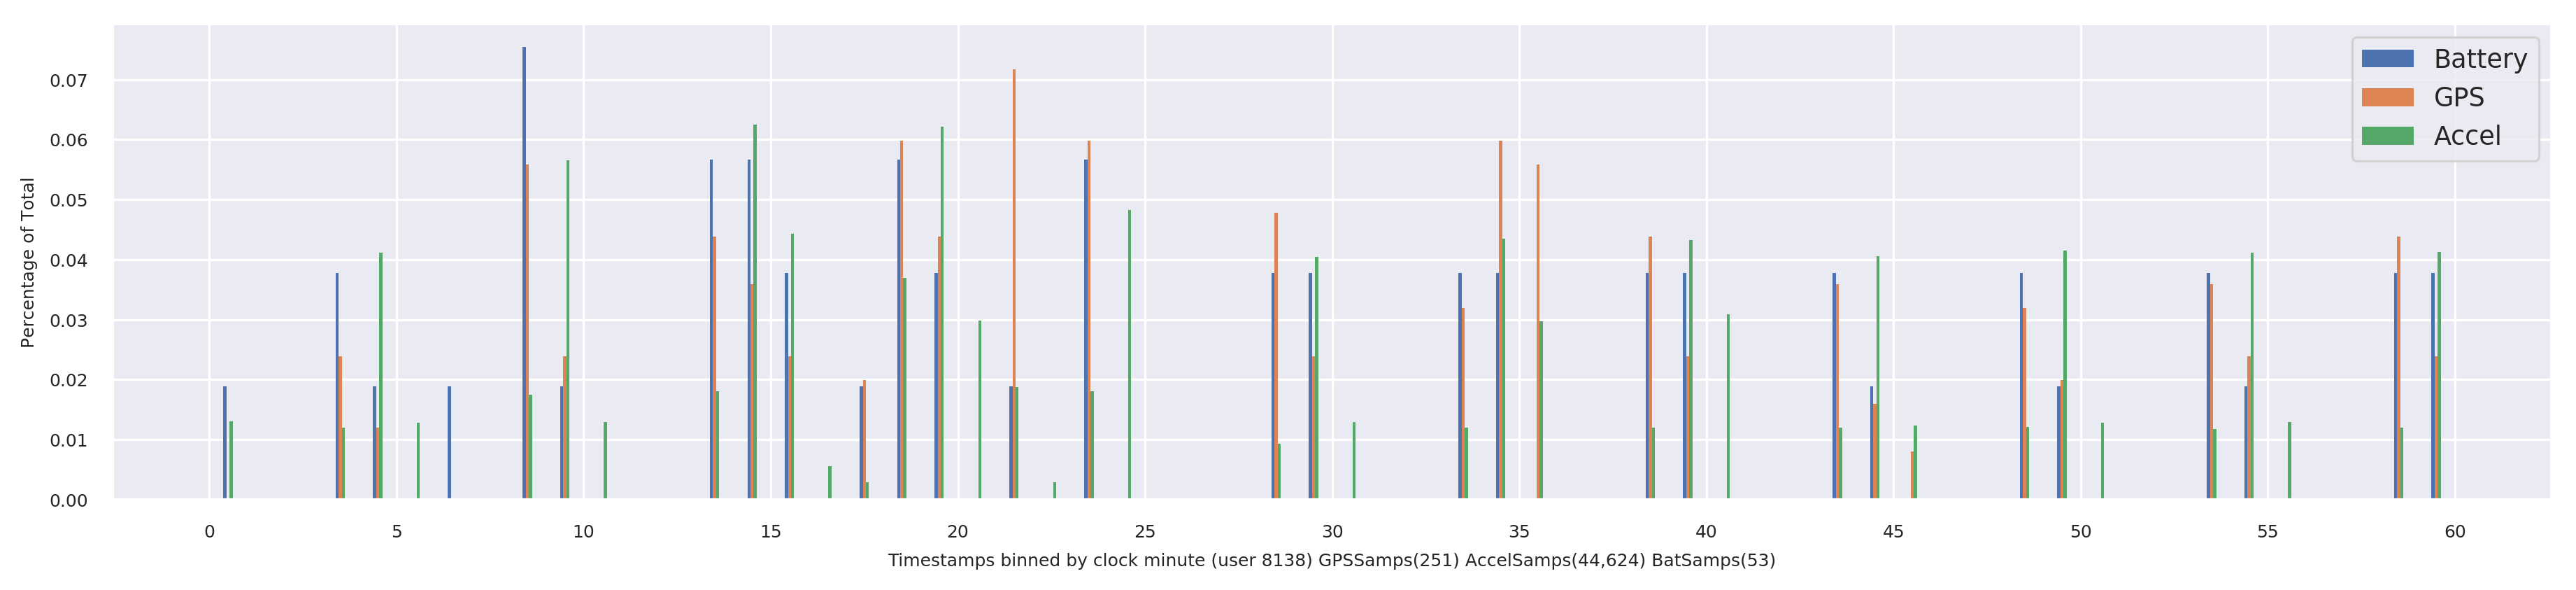

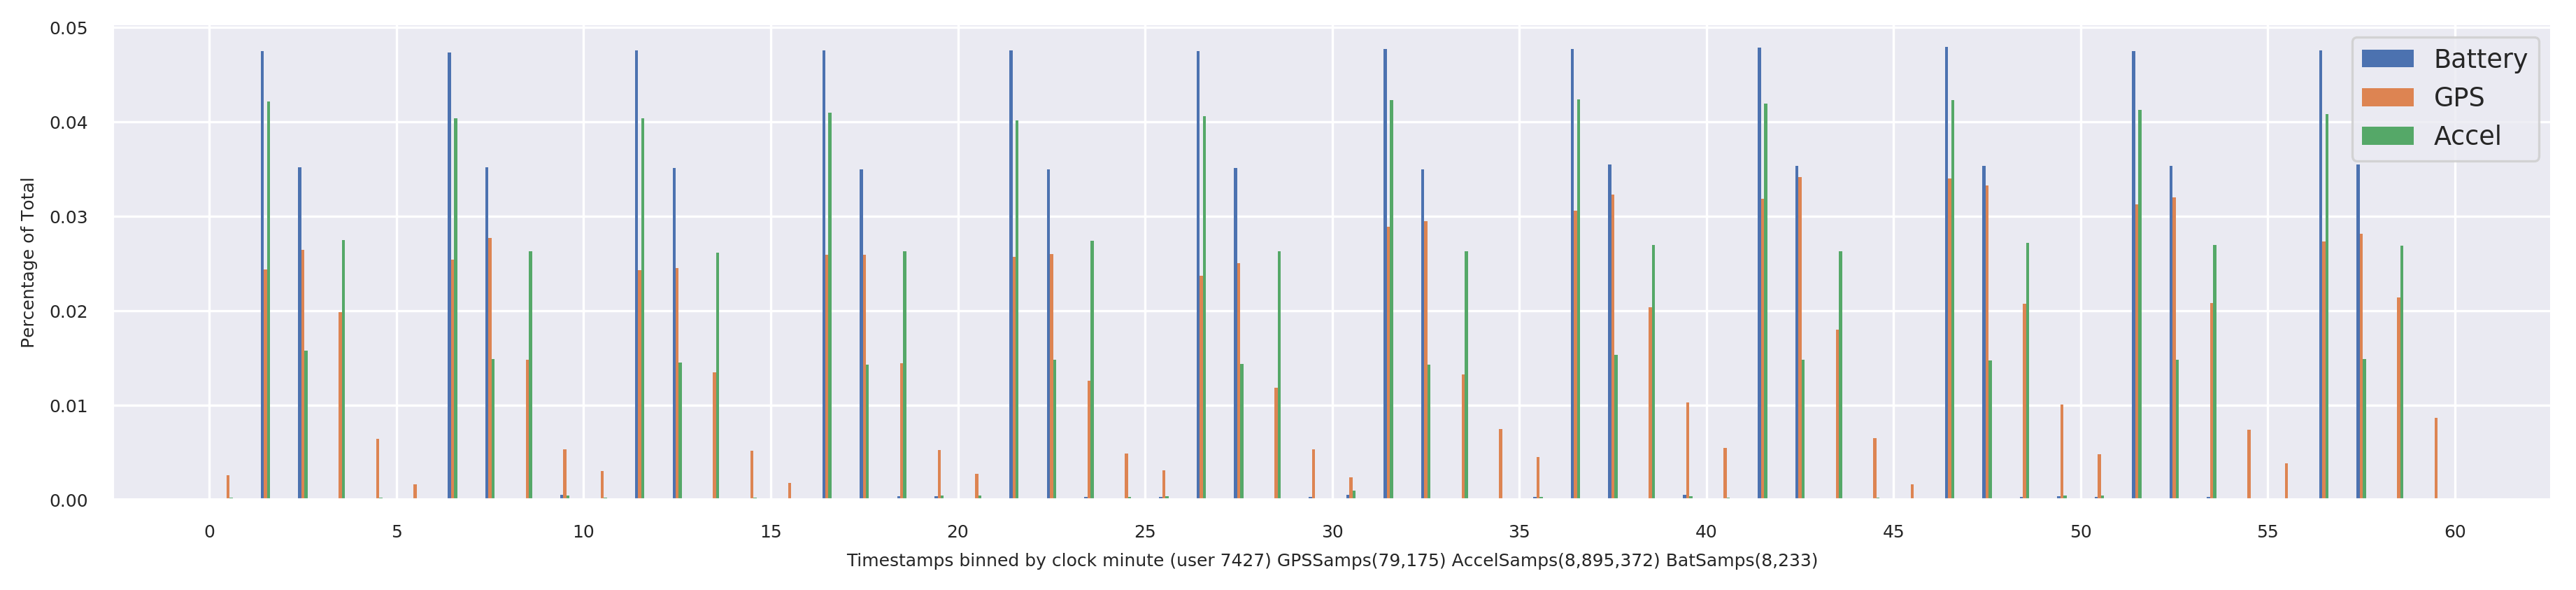

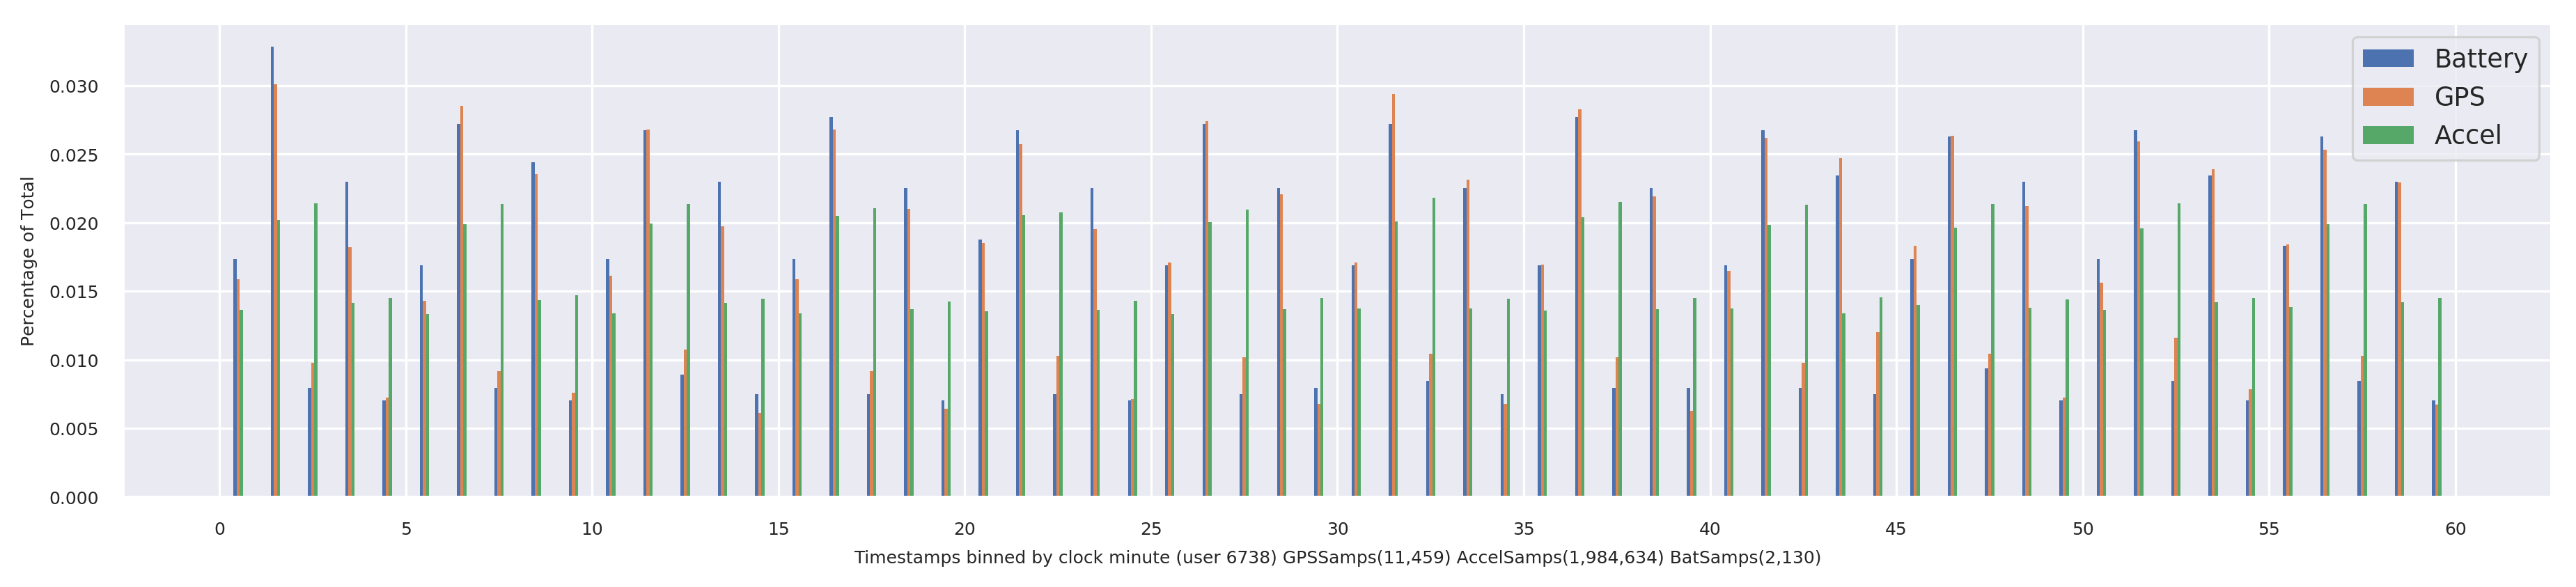

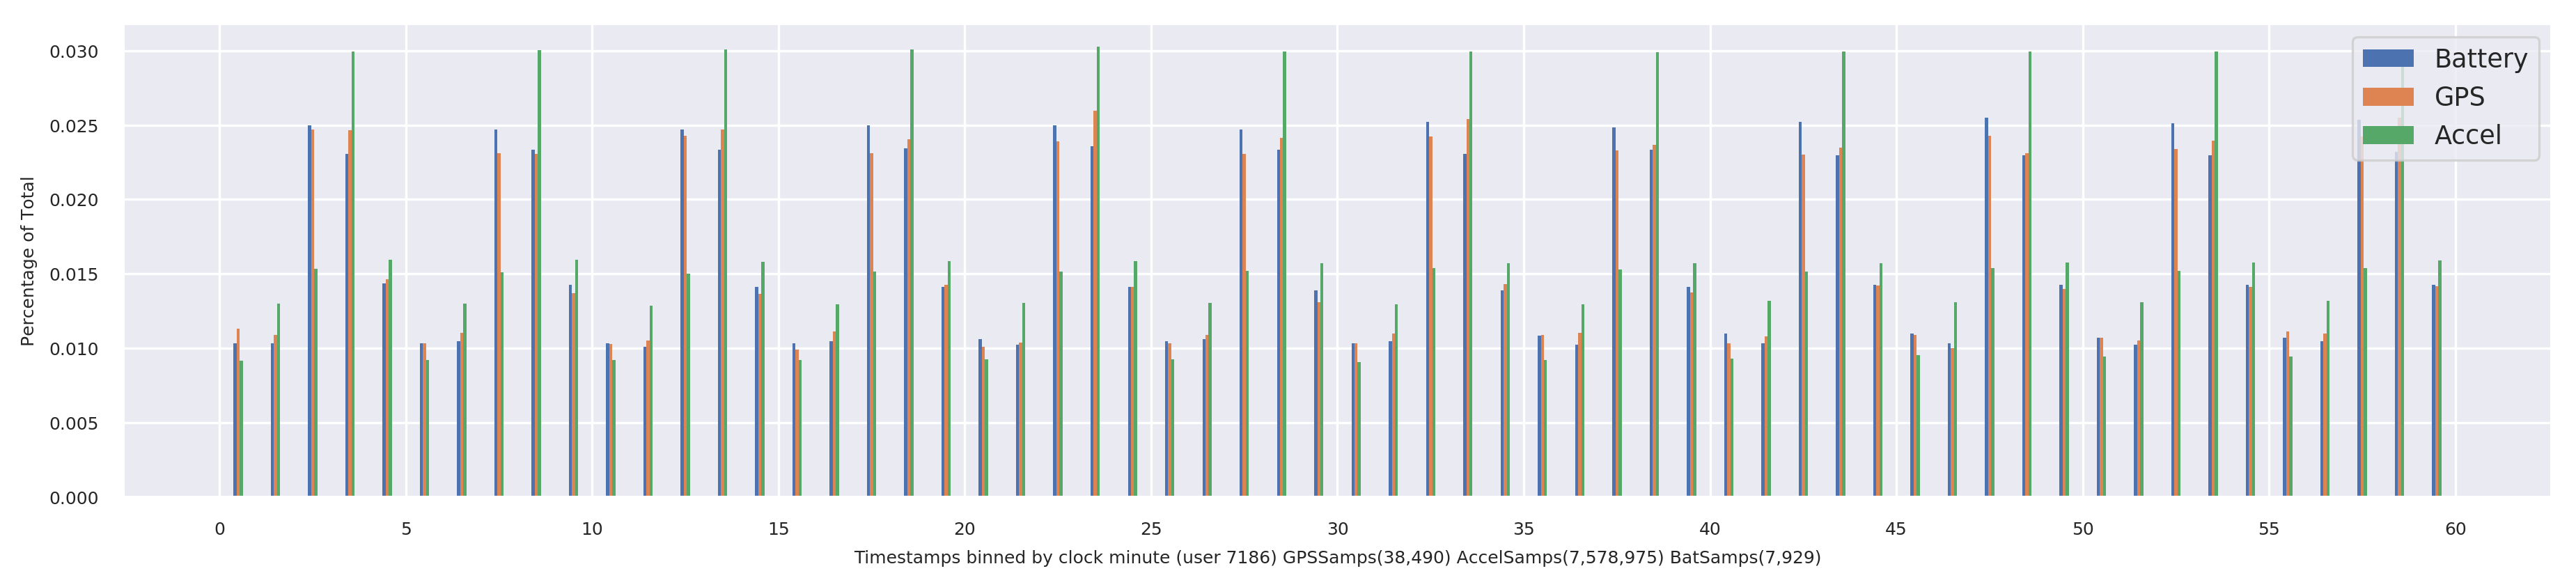

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rnd
import datetime
import psycopg2
import psycopg2.extras
import re
import os
import seaborn 
import collections

"""
Draws a graph showing the distribution of timestamps relative to
minutes of the hour. As we understand it, the Ethica software attempts
to keep the duty cycles aligned with clock time. If this is the case,
then we should see peaks of samples occurring at 0, 5, 10, 15...55 minutes 
after the hour.
"""

# set higher dpi for HTML display
mpl.rcParams['figure.dpi'] = 300

seaborn.set()
seaborn.set_context('paper')

# expects to find connection credentials in local runtime environment
db_host=os.environ['SQL_LOCAL_SERVER']
db_host_port=int(os.environ['SQL_LOCAL_PORT'])
db_user=os.environ['SQL_USER']
db_name=os.environ['SQL_DB']
db_schema=os.environ['SQL_SCHEMA']

# SQL commands for getting data out of the tables of interest
user_dc_signals_sql = """SELECT count(1), user_id, record_time
                         FROM level_0.tmpsskbatt
                         GROUP BY user_id, record_time
                         ORDER BY user_id, record_time;
                         """
user_gps_signals_sql = """SELECT count(1), user_id, record_time
                         FROM level_0.tmpsskgps
                         WHERE user_id = %s
                         GROUP BY user_id, record_time
                         ORDER BY user_id, record_time;
                         """
user_accel_signals_sql = """SELECT count(1), user_id, record_time
                         FROM level_0.tmpsskaccel
                         WHERE user_id = %s
                         GROUP BY user_id, record_time
                         ORDER BY user_id, record_time;
                         """

# Create connection to DB...
with psycopg2.connect(user=db_user,
                    host=db_host,
                    port=db_host_port,
                    database=db_name) as conn:

    # Get dc data and user list...
    cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    cur.execute(user_dc_signals_sql)
    dc_signals = cur.fetchall()
    users = set([x['user_id'] for x in dc_signals])

    numfigs = 1
    numusers = len(users)
    numgraphs = 10

    i = 0
    rnd.seed(17) # ensure same group of users chosen each time
    bins = list(range(0,61))
    
    graph_users = rnd.sample(users,numgraphs)
    for user in graph_users:

        
        # Get GPS data for this user
        cur.execute(user_gps_signals_sql%user)
           
        # get the GPS time signals into an array of minutes
        gps_minutes = []
        while True:
            gps_signals = cur.fetchmany(1000000)
            if not gps_signals:
                break
            for rec in gps_signals:
                timestamp = rec['record_time']
                clockmin = timestamp.minute 
                gps_minutes.append( clockmin )
                
        # Get Accel data for this user
        cur.execute(user_accel_signals_sql%user)
           
        # get the Accel time signals into an array of minutes
        if True:
            accel_minutes = []
            while True:
                accel_signals = cur.fetchmany(1000000)
                if not accel_signals:
                    break
                for rec in accel_signals:
                    timestamp = rec['record_time']
                    clockmin = timestamp.minute 
                    accel_minutes.append( clockmin )
                  
        # get the DC battery time signals into an array
        user_dc_signals = [x['record_time'] for x in dc_signals if x['user_id'] == user]
        dc_minutes = []
        for timestamp in user_dc_signals:
            clockmin = timestamp.minute 
            dc_minutes.append( clockmin )

        # plot histogram of minute values
        f, axs = plt.subplots(1,1,figsize=(15,3))
        #f.suptitle("Ethica GPS/Battery Timestamp Minute Alignments (Saskatoon)")
        datasets = [dc_minutes,gps_minutes,accel_minutes]
        names = ["Battery","GPS", "Accel"]
        axs.hist(datasets, bins=bins, label=names, linewidth=0, rwidth=0.75, density=True)
        ticklabels = [str(x) for x in bins]
        #axs.hist(gps_minutes, bins=bins, alpha=0.5, width=1, label='GPS', density=True)
        #axs.hist(dc_minutes, bins=bins, alpha=0.5, width=1, label="Battery", density=True)
        #axs.hist(accel_minutes, bins=bins, alpha=0.5, width=1, label="Accel", density=True)
        axs.legend(loc='upper right')
        axs.set_xlabel(f'Timestamps binned by clock minute (user {user}) GPSSamps({len(gps_minutes):,}) AccelSamps({len(accel_minutes):,}) BatSamps({len(dc_minutes):,})',fontsize=6)
        axs.set_ylabel('Percentage of Total',fontsize=6)
        axs.tick_params(axis='both', which='major', labelsize=6)
        axs.tick_params(axis='both', which='minor', labelsize=4)
        axs.set_xticks(bins[::5])
        axs.set_xticklabels(ticklabels[::5])
        i += 1


These graphs show frequency distributions of timestamps across the 60 minutes of the hour (with all redundant records collapsed into singletons so they don't overcount). My expectation was that columns of peak activity for all three sources would align with the 0th minute of each DC, but that does not appear to be the case. 

For example, the bottom-most graph (user 7186) shows peaks for Accel on minute 3,8,13.. of each DC, while peaks for Battery and GPS are on the 2s and 3s. The 0s are in fact consistently the lowest bar in each DC. But on the graph above that (user 6738) the peaks for Battery and GPS are on the 1s of each DC while the Accel peaks are on the 2s.

As we scan each of the graphs, what emerges is that there is no consistent synchronization between the three signals, although they do all exhibit 5-minute periodicity. Assuming these 10 random cases are representative of the rest of the dataset, it seems that correlation between the signals at any frequency lower than 5-minutes would present significant challenges.

## Conclusion

At first glance, the excess data contained in the files appeared problematic, but upon deeper analysis, it seems managable. If we investigate the cause of the redundancy further, we might be able to resolve them, but this would only increase our unique retained sample rate by 5%. The more prudent course might be to simply drop all redundant samples and process the true singletons only.

We should probably still follow up with Mohammad, to be sure there aren't deeper issues here that we haven't fully understood, but doing so should probably not delay the ingest and ToP process on the existing data.